In [3]:
import pandas as pd
import numpy as np
import sklearn

import sys
import numpy.linalg as la
import numpy as np
import nibabel as nib
import pandas as pd
#import scipy.io
import patsy

In [14]:
def adjust_nums(numerical_covariates, drop_idxs):
    # if we dropped some values, have to adjust those with a larger index.
    if numerical_covariates is None: return drop_idxs
    return [nc - sum(nc < di for di in drop_idxs) for nc in numerical_covariates]

def design_mat(mod, numerical_covariates, batch_levels):
    # require levels to make sure they are in the same order as we use in the
    # rest of the script.
    design = patsy.dmatrix("~ 0 + C(batch, levels=%s)" % str(batch_levels),
                                                  mod, return_type="dataframe")

    mod = mod.drop(["batch"], axis=1)
    numerical_covariates = list(numerical_covariates)
    sys.stderr.write("found %i batches\n" % design.shape[1])
    other_cols = [c for i, c in enumerate(mod.columns)
                  if not i in numerical_covariates]
    factor_matrix = mod[other_cols]
    design = pd.concat((design, factor_matrix), axis=1)
    if numerical_covariates is not None:
        sys.stderr.write("found %i numerical covariates...\n"
                            % len(numerical_covariates))
        for i, nC in enumerate(numerical_covariates):
            cname = mod.columns[nC]
            sys.stderr.write("\t{0}\n".format(cname))
            design[cname] = mod[mod.columns[nC]]
    sys.stderr.write("found %i categorical variables:" % len(other_cols))
    sys.stderr.write("\t" + ", ".join(other_cols) + '\n')
    return design


def combat(data, batch, model=None, numerical_covariates=None):
    """Correct for batch effects in a dataset

    Parameters
    ----------
    data : pandas.DataFrame
        A (n_features, n_samples) dataframe of the expression or methylation
        data to batch correct
    batch : pandas.Series
        A column corresponding to the batches in the data, with index same as
        the columns that appear in ``data``
    model : patsy.design_info.DesignMatrix, optional
        A model matrix describing metadata on the samples which could be
        causing batch effects. If not provided, then will attempt to coarsely
        correct just from the information provided in ``batch``
    numerical_covariates : list-like
        List of covariates in the model which are numerical, rather than
        categorical

    Returns
    -------
    corrected : pandas.DataFrame
        A (n_features, n_samples) dataframe of the batch-corrected data
    """
    if isinstance(numerical_covariates, str):
        numerical_covariates = [numerical_covariates]
    if numerical_covariates is None:
        numerical_covariates = []

    if model is not None and isinstance(model, pd.DataFrame):
        model["batch"] = list(batch)
    else:
        model = pd.DataFrame({'batch': batch})

    batch_items = model.groupby("batch").groups.items()
    batch_levels = [k for k, v in batch_items]
    batch_info = [v for k, v in batch_items]
    n_batch = len(batch_info)
    n_batches = np.array([len(v) for v in batch_info])
    n_array = float(sum(n_batches))

    # drop intercept
    drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
    drop_idxs = [list(model.columns).index(cdrop) for cdrop in drop_cols]
    model = model[[c for c in model.columns if not c in drop_cols]]
    numerical_covariates = [list(model.columns).index(c) if isinstance(c, str) else c
            for c in numerical_covariates if not c in drop_cols]

    design = design_mat(model, numerical_covariates, batch_levels)

    sys.stderr.write("Standardizing Data across genes.\n")
    B_hat = np.dot(np.dot(la.inv(np.dot(design.T, design)), design.T), data.T)
    grand_mean = np.dot((n_batches / n_array).T, B_hat[:n_batch,:])
    var_pooled = np.dot(((data - np.dot(design, B_hat).T)**2), np.ones((int(n_array), 1)) / int(n_array))

    stand_mean = np.dot(grand_mean.T.reshape((len(grand_mean), 1)), np.ones((1, int(n_array))))
    tmp = np.array(design.copy())
    tmp[:,:n_batch] = 0
    stand_mean  += np.dot(tmp, B_hat).T

    s_data = ((data - stand_mean) / np.dot(np.sqrt(var_pooled), np.ones((1, int(n_array)))))

    sys.stderr.write("Fitting L/S model and finding priors\n")
    batch_design = design[design.columns[:n_batch]]
    gamma_hat = np.dot(np.dot(la.inv(np.dot(batch_design.T, batch_design)), batch_design.T), s_data.T)

    delta_hat = []

    for i, batch_idxs in enumerate(batch_info):
        #batches = [list(model.columns).index(b) for b in batches]
        delta_hat.append(s_data[batch_idxs].var(axis=1))

    gamma_bar = gamma_hat.mean(axis=1) 
    t2 = gamma_hat.var(axis=1)
   

    a_prior = list(map(aprior, delta_hat))
    b_prior = list(map(bprior, delta_hat))

    sys.stderr.write("Finding parametric adjustments\n")
    gamma_star, delta_star = [], []
    for i, batch_idxs in enumerate(batch_info):
        #print '18 20 22 28 29 31 32 33 35 40 46'
        #print batch_info[batch_id]

        temp = it_sol(s_data[batch_idxs], gamma_hat[i],
                     delta_hat[i], gamma_bar[i], t2[i], a_prior[i], b_prior[i])

        gamma_star.append(temp[0])
        delta_star.append(temp[1])

    sys.stdout.write("Adjusting data\n")
    bayesdata = s_data
    gamma_star = np.array(gamma_star)
    delta_star = np.array(delta_star)


    for j, batch_idxs in enumerate(batch_info):

        dsq = np.sqrt(delta_star[j,:])
        dsq = dsq.reshape((len(dsq), 1))
        denom =  np.dot(dsq, np.ones((1, n_batches[j])))
        numer = np.array(bayesdata[batch_idxs] - np.dot(batch_design.loc[batch_idxs], gamma_star).T)

        bayesdata[batch_idxs] = numer / denom
   
    vpsq = np.sqrt(var_pooled).reshape((len(var_pooled), 1))
    bayesdata = bayesdata * np.dot(vpsq, np.ones((1, int(n_array)))) + stand_mean
 
    return bayesdata

def it_sol(sdat, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001):
    n = (1 - np.isnan(sdat)).sum(axis=1)
    g_old = g_hat.copy()
    d_old = d_hat.copy()

    change = 1
    count = 0
    while change > conv:
        #print g_hat.shape, g_bar.shape, t2.shape
        g_new = postmean(g_hat, g_bar, n, d_old, t2)
        sum2 = ((sdat - np.dot(g_new.values.reshape((g_new.shape[0], 1)), np.ones((1, sdat.shape[1])))) ** 2).sum(axis=1)
        d_new = postvar(sum2, n, a, b)
       
        change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())
        g_old = g_new #.copy()
        d_old = d_new #.copy()
        count = count + 1
    adjust = (g_new, d_new)
    return adjust 

    

def aprior(gamma_hat):
    m = gamma_hat.mean()
    s2 = gamma_hat.var()
    return (2 * s2 +m**2) / s2

def bprior(gamma_hat):
    m = gamma_hat.mean()
    s2 = gamma_hat.var()
    return (m*s2+m**3)/s2

def postmean(g_hat, g_bar, n, d_star, t2):
    return (t2*n*g_hat+d_star * g_bar) / (t2*n+d_star)

def postvar(sum2, n, a, b):
    return (0.5 * sum2 + b) / (n / 2.0 + a - 1.0)

def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [10]:
'''
hcp_si = pd.concat([all_site[all_site['tech'] == 'SI'], all_site[all_site['tech'] == 'T1w_HCP']])

mean = np.mean(hcp_si[['int','ext','tot']][hcp_si['int'] != 0])

hcp_si['int'][hcp_si['int'] == 0] = mean['int']
hcp_si['ext'][hcp_si['ext'] == 0] = mean['ext']
hcp_si['tot'][hcp_si['tot'] == 0] = mean['tot']
hcp_si['int'][hcp_si['int'].isna()] = mean['int']
hcp_si['ext'][hcp_si['ext'].isna()] = mean['ext']
hcp_si['tot'][hcp_si['tot'].isna()] = mean['tot']


hcp_si.iloc[:,0:444] = hcp_si.iloc[:,0:444].apply(lambda x: x.fillna(x.mean()),axis=0)
'''

"\nhcp_si = pd.concat([all_site[all_site['tech'] == 'SI'], all_site[all_site['tech'] == 'T1w_HCP']])\n\nmean = np.mean(hcp_si[['int','ext','tot']][hcp_si['int'] != 0])\n\nhcp_si['int'][hcp_si['int'] == 0] = mean['int']\nhcp_si['ext'][hcp_si['ext'] == 0] = mean['ext']\nhcp_si['tot'][hcp_si['tot'] == 0] = mean['tot']\nhcp_si['int'][hcp_si['int'].isna()] = mean['int']\nhcp_si['ext'][hcp_si['ext'].isna()] = mean['ext']\nhcp_si['tot'][hcp_si['tot'].isna()] = mean['tot']\n\n\nhcp_si.iloc[:,0:444] = hcp_si.iloc[:,0:444].apply(lambda x: x.fillna(x.mean()),axis=0)\n"

In [22]:
for net in range(1,8):    
    conn = pd.read_csv('444_conn'+str(net)+'.csv',index_col=0)
    conn.iloc[:,:conn.shape[1]-6] = conn.iloc[:,:conn.shape[1]-6].apply(lambda x: x.fillna(x.mean()),axis=0)

    mean = np.mean(conn[['int','ext','tot']][conn['int'] != 0])

    conn['int'][conn['int'] == 0] = mean['int']
    conn['ext'][conn['ext'] == 0] = mean['ext']
    conn['tot'][conn['tot'] == 0] = mean['tot']
    conn['int'][conn['int'].isna()] = mean['int']
    conn['ext'][conn['ext'].isna()] = mean['ext']
    conn['tot'][conn['tot'].isna()] = mean['tot']
    
    mod = patsy.dmatrix("~ age + sex + int+ ext + tot", conn, return_type="dataframe")
    
    ebat = combat(conn.iloc[:, 0:(conn.shape[1]-6)].transpose(), conn['group'], mod)

    after_combat = ebat.transpose()
    
    after_combat = pd.concat([after_combat, conn.iloc[:,(conn.shape[1]-6):]], axis=1)
    
    print(after_combat.shape)
    
    after_combat.to_csv('444_conn'+str(net)+'_after.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

Adjusting data
(2389, 3576)


found 3 batches
found 0 numerical covariates...
found 5 categorical variables:	sex[T.M], age, int, ext, tot
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
(2389, 2781)


found 3 batches
found 0 numerical covariates...
found 5 categorical variables:	sex[T.M], age, int, ext, tot
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
(2389, 2284)


found 3 batches
found 0 numerical covariates...
found 5 categorical variables:	sex[T.M], age, int, ext, tot
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
(2389, 1897)


found 3 batches
found 0 numerical covariates...
found 5 categorical variables:	sex[T.M], age, int, ext, tot
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
(2389, 1281)


found 3 batches
found 0 numerical covariates...
found 5 categorical variables:	sex[T.M], age, int, ext, tot
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
(2389, 2634)


found 3 batches
found 0 numerical covariates...
found 5 categorical variables:	sex[T.M], age, int, ext, tot
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
(2389, 5784)


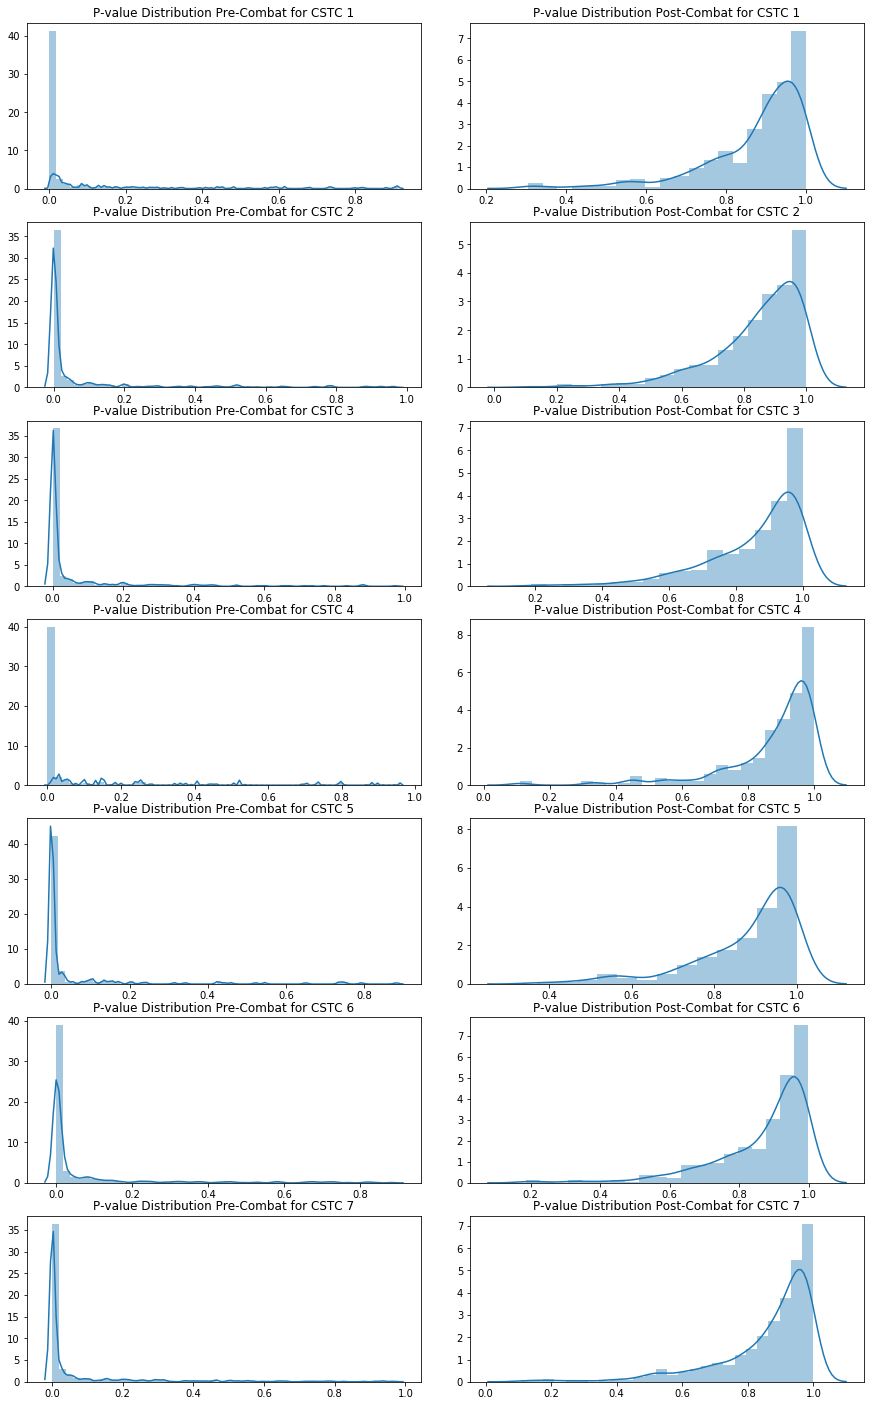

In [53]:
plt.figure(figsize=(15, 25))

num_rows = 7
num_cols = 2

row_width = 6
space_width = 2

num_sep_rows = lambda x: int((x-1)/2)
grid = (num_rows,row_width*num_cols + space_width*num_sep_rows(num_cols))

ax_list = []

for ind_col in range(num_cols):
    for ind_row in range(num_rows):
        grid_col = row_width*ind_col + space_width*num_sep_rows(ind_col+1)
        grid_row = ind_row

        ax_list += [plt.subplot2grid(grid, (grid_row, grid_col), colspan=row_width)]

plt.subplots_adjust(wspace=2)



for net in range(1,8):
    conn = pd.read_csv('122_conn'+str(net)+'.csv',index_col=0)
    conn_a = pd.read_csv('122_conn'+str(net)+'_after.csv',index_col=0)
    nn = conn.shape[1]-6
    p_v = []
    for i in range(nn):
        p = stats.f_oneway(conn[conn.columns[i]][conn['group'] == 0].fillna(0), 
             conn[conn.columns[i]][conn['group'] == 1].fillna(0),
             conn[conn.columns[i]][conn['group'] == 2].fillna(0))[1]
        p_v.append(p)
    
    p_v_a = []
    for i in range(nn):
        p = stats.f_oneway(conn_a[conn_a.columns[i]][conn_a['group'] == 0].fillna(0), 
             conn_a[conn_a.columns[i]][conn_a['group'] == 1].fillna(0),
             conn_a[conn_a.columns[i]][conn_a['group'] == 2].fillna(0))[1]
        p_v_a.append(p)
    
    
    sns.distplot(p_v, ax=ax_list[net-1]).set_title('P-value Distribution Pre-Combat for CSTC '+ str(net))
    #plt.xlim((1,0))
    #plt.savefig('p_Pre.png')
    
    
    sns.distplot(p_v_a, ax=ax_list[net+6]).set_title('P-value Distribution Post-Combat for CSTC '+ str(net))
    #plt.xlim((1,0))
    #plt.savefig('p_Post.png')
    

plt.savefig('conn_combat.png')

    